In [ ]:
import torch
import torch.nn as nn
from torch_geometric.datasets import OGB_MAG
from torch_geometric.loader import HGTLoader
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn.conv import HeteroConv
from torch_geometric.transforms import ToUndirected
from inductive import to_inductive
from collections import Counter
from matplotlib.colors import ListedColormap

/Users/patrickmartins/Desktop/Masters 3/Deep_Learning/Project/GNN-SSL-Project-for-Deep-Learning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Encoder Architecture

In [2]:
class graphSAGE_ENCODER(nn.Module):
    def __init__(self, edge_types, hidden_dim):
        super().__init__()
        self.conv1 = HeteroConv({edge_type: SAGEConv(
            (-1, -1), hidden_dim) for edge_type in edge_types}, aggr='sum')
        self.conv2 = HeteroConv({edge_type: SAGEConv(
            (-1, -1), hidden_dim) for edge_type in edge_types}, aggr='sum')
        # layer 3
        self.conv3 = HeteroConv({edge_type: SAGEConv(
            (-1, -1), hidden_dim) for edge_type in edge_types}, aggr='sum')

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = self.conv3(x_dict, edge_index_dict)
        return x_dict

Import the training partition of the dataset

In [3]:
dataset = OGB_MAG(root='data/',
                  transform=ToUndirected(),
                  preprocess="metapath2vec")[0]

num_neighbors = [5, 5, 5]
hidden_dim = 256
out_channels = max(dataset['paper'].y).item() + 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

node_type = "paper"
dataset_inductive = to_inductive(dataset.clone(), node_type)
dataset = dataset.to(device)
dataset_inductive = dataset_inductive.to(device)

train_batch = NeighborLoader(dataset_inductive, 
                        num_neighbors=num_neighbors, 
                        input_nodes=('paper', dataset_inductive['paper'].train_mask),
                        batch_size=128, 
                        shuffle=True, 
                        num_workers=4)

Build dictionary for nodes

In [4]:
def build_x_dict(batch):
    x_dict = {}
    for node_type in batch.node_types:
        x_dict[node_type] = batch[node_type].x.to(device)
    return x_dict

Declare the encoder

In [5]:
encoder = graphSAGE_ENCODER(dataset.edge_types, hidden_dim).to(device)
state = torch.load("best_encoder_b128_h256.pth", map_location=device)
encoder.load_state_dict(state)
encoder.eval()  # ensure deterministic



graphSAGE_ENCODER(
  (conv1): HeteroConv(num_relations=7)
  (conv2): HeteroConv(num_relations=7)
  (conv3): HeteroConv(num_relations=7)
)

Sample a batch

In [6]:
batch = next(iter(train_batch))
x_dict = build_x_dict(batch)
edge_index_dict = {edge_type : batch[edge_type].edge_index for edge_type in batch.edge_types}

Get the venue IDs saved into vector v

In [7]:
with torch.no_grad():
    x = encoder(x_dict, edge_index_dict)
    v = batch["paper"].y
    print(v)
    paper_emb = x['paper'].cpu().numpy()



tensor([213, 291, 170,  ...,   1, 246, 249])


Check distributions of venues

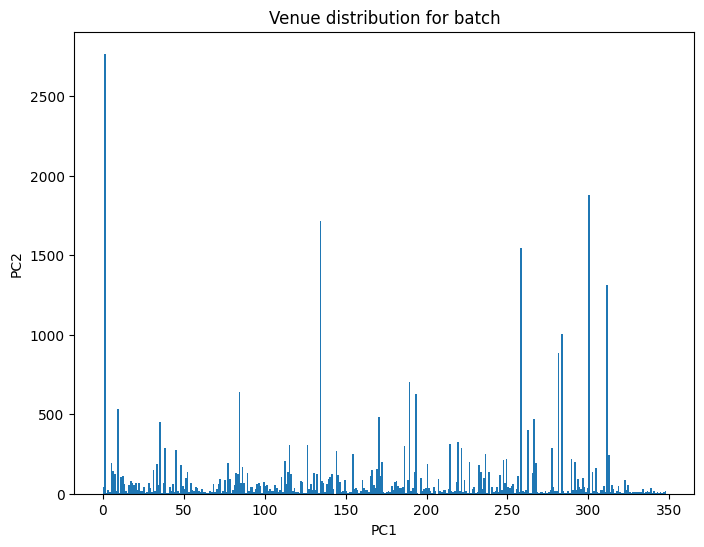

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(v, bins=348)
plt.title("Venue distribution for batch")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Create color map for top 5 most common IDs of venues in the batch

In [ ]:

# Get values and respective counts
values, counts = torch.unique(v, return_counts=True)

# Sort counts in descending order and get the indices
sorted_counts, sorted_idx = torch.sort(counts, descending=True)

# Pick the top 5
top_k = 5
top_values = values[sorted_idx][:top_k]
top_counts = sorted_counts[:top_k]

# Convert to numbers for display
top_values = top_values.tolist()
top_counts = top_counts.tolist()

print(top_values)

colors = ListedColormap(["red", "yellow", "green", "blue", "orange", "gray"])

clr_assignment = []

for i in range(len(v)):
    if v[i] in top_values:
        ix = top_values.index(v[i])

        # Append color for a venue in top 5 represented group
        clr_assignment.append(ix)

    else:
        # Append neutral color index (gray)
        clr_assignment.append(5)




[1, 300, 134, 258, 311]


Perform PCA on the embeddings

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


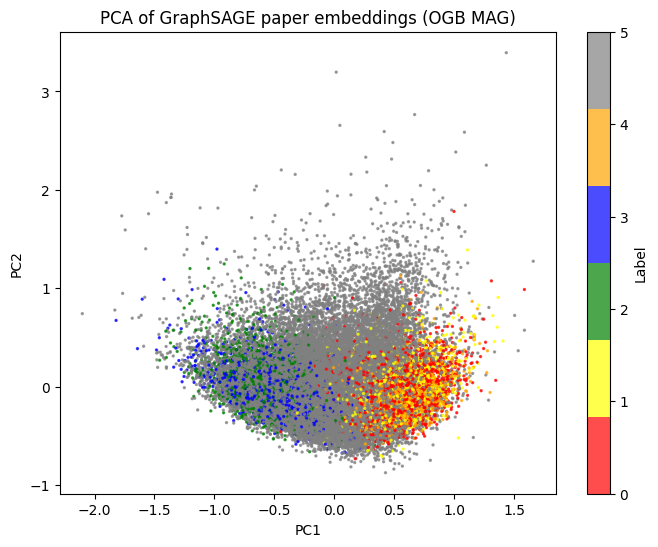

In [ ]:
# Assume x_dict['paper'] is your frozen embeddings tensor
embeddings = x_dict['paper'].cpu().numpy()  # move to CPU first

# Optional: subsample if memory is tight



# Run PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=2, cmap=colors, alpha=0.7, c=clr_assignment)
plt.title("PCA of GraphSAGE paper embeddings (OGB MAG)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Label')
plt.show()

Plot 3 PCA Components

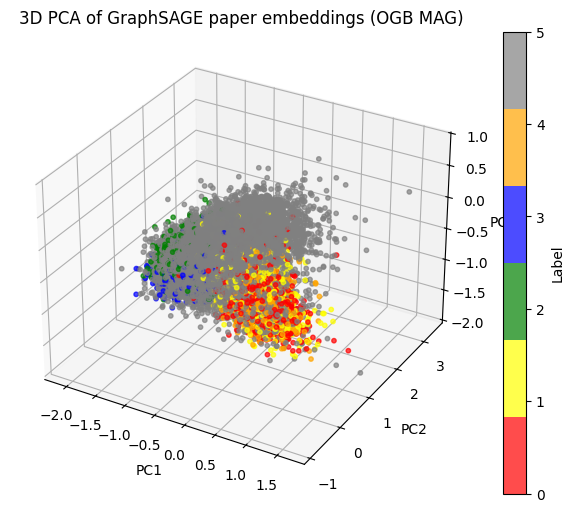

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=3)
emb_3d = pca.fit_transform(embeddings)  

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    emb_3d[:,0], emb_3d[:,1], emb_3d[:,2], 
    c=clr_assignment,       
    cmap=colors,          
    s=10,                  
    alpha=0.7
)

cbar = plt.colorbar(sc)
cbar.set_label('Label')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title("3D PCA of GraphSAGE paper embeddings (OGB MAG)")
plt.show()